<a href="https://colab.research.google.com/github/vgorbikov/image_processing/blob/main/01_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка изображений
В этом задании предстоит поработать с фильтрацией шумов на изображениях, попутно познакомиться с работой линейных и нелинейных фильтров, а также с операциями прореживания и интерполяции.

Пользоваться готовыми решениями нельзя, если не сказано обратного.

In [8]:
import random
from numpy import ndarray

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import IPython
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Введите имя папки с заданием в FOLDER_NAME. Переменная FOLDER_PATH содержит полный путь к папке в Google Drive.
FOLDER_NAME = 'assignments/01-image-processing/'
FOLDER_PATH = '/content/drive/My Drive/{}'.format(FOLDER_NAME)


Mounted at /content/drive


# 1. Фильтрация изображения


- Откройте картинку `toucan.jpeg` с помощью библиотеки `PIL` и отобразите её. Для удобства преобразуйте изображение в массив numpy и выведите её размер.

(750, 1000)


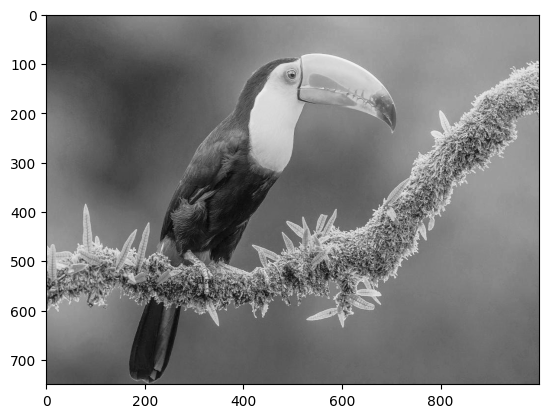

In [6]:
with Image.open(FOLDER_PATH + 'data/toucan.jpeg', 'r') as img_1:
  img_1_arr = np.asarray(img_1)
  print(img_1_arr.shape)
  plt.imshow(img_1_arr, cmap='Greys_r')

- Проверим, как шум искажает изображение и как мы можем от него избавиться. Рассмотрим один из видов шумов - **дробовой шум (shot noise)**, который встречается, например, в работе электронных утройств и связан с дискретной природой заряженных частиц. В контексте изображений дробой шум проявляет себя как наличие случайно разбросанных пикселей с очень большим значением.

 Реализуйте функцию `get_img_with_shot_noise`, которая принимает на вход изображение (numpy array) и параметр `ratio`, отвечающий за долю пикселей, которые должны принять большое значение. Возвращает функция зашумленную картинку.

 Присвойте $5\%$ пикселей значение, соответствующее белому цвету в grayscale режиме, затем отобразите картинку.

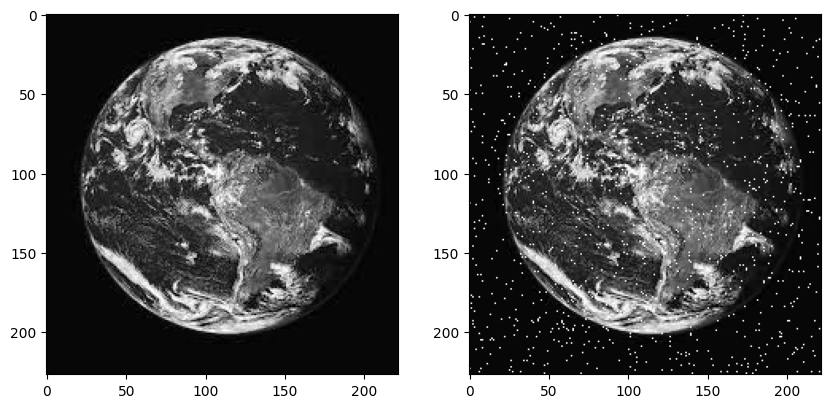

In [ ]:
# Пример дробового шума на изображении
IPython.display.Image(filename=FOLDER_PATH + 'data/shot_noise_example.png', width=700)

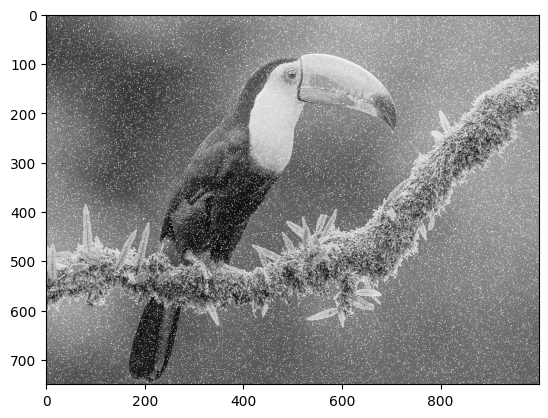

In [51]:
def get_img_with_shot_noise(img: ndarray, ratio: float = 0.05, shot_value: int = 255):
    shot_count = round(img.size*ratio)
    height, width = img.shape
    img = np.copy(img)
    for i in range(shot_count):
      img[round(height*random.random())-1][round(width*random.random())-1] = shot_value
    return img

img_noized = get_img_with_shot_noise(img_1_arr)
plt.imshow(img_noized, cmap='Greys_r')

- Теперь у нас есть картинка с дробовым шумом. Чтобы от него избавиться, воспользуемся **медианным фильтром** - нелинейный фильтр, в котором каждый выходной пиксель получается вычислением медианы по всем соседям соответсвующего входного пикселя (в случае окна $3\times 3$).

 Реализуйте функцию `median_filter`, принимающую на вход картинку и размер окна для нахождения медианы. Отфильруйте изображение с помощью окна $3\times 3$. Значения на границе оставьте неизменными. Перед фильтрацией проверьте работу функции на примере с картинки ниже.

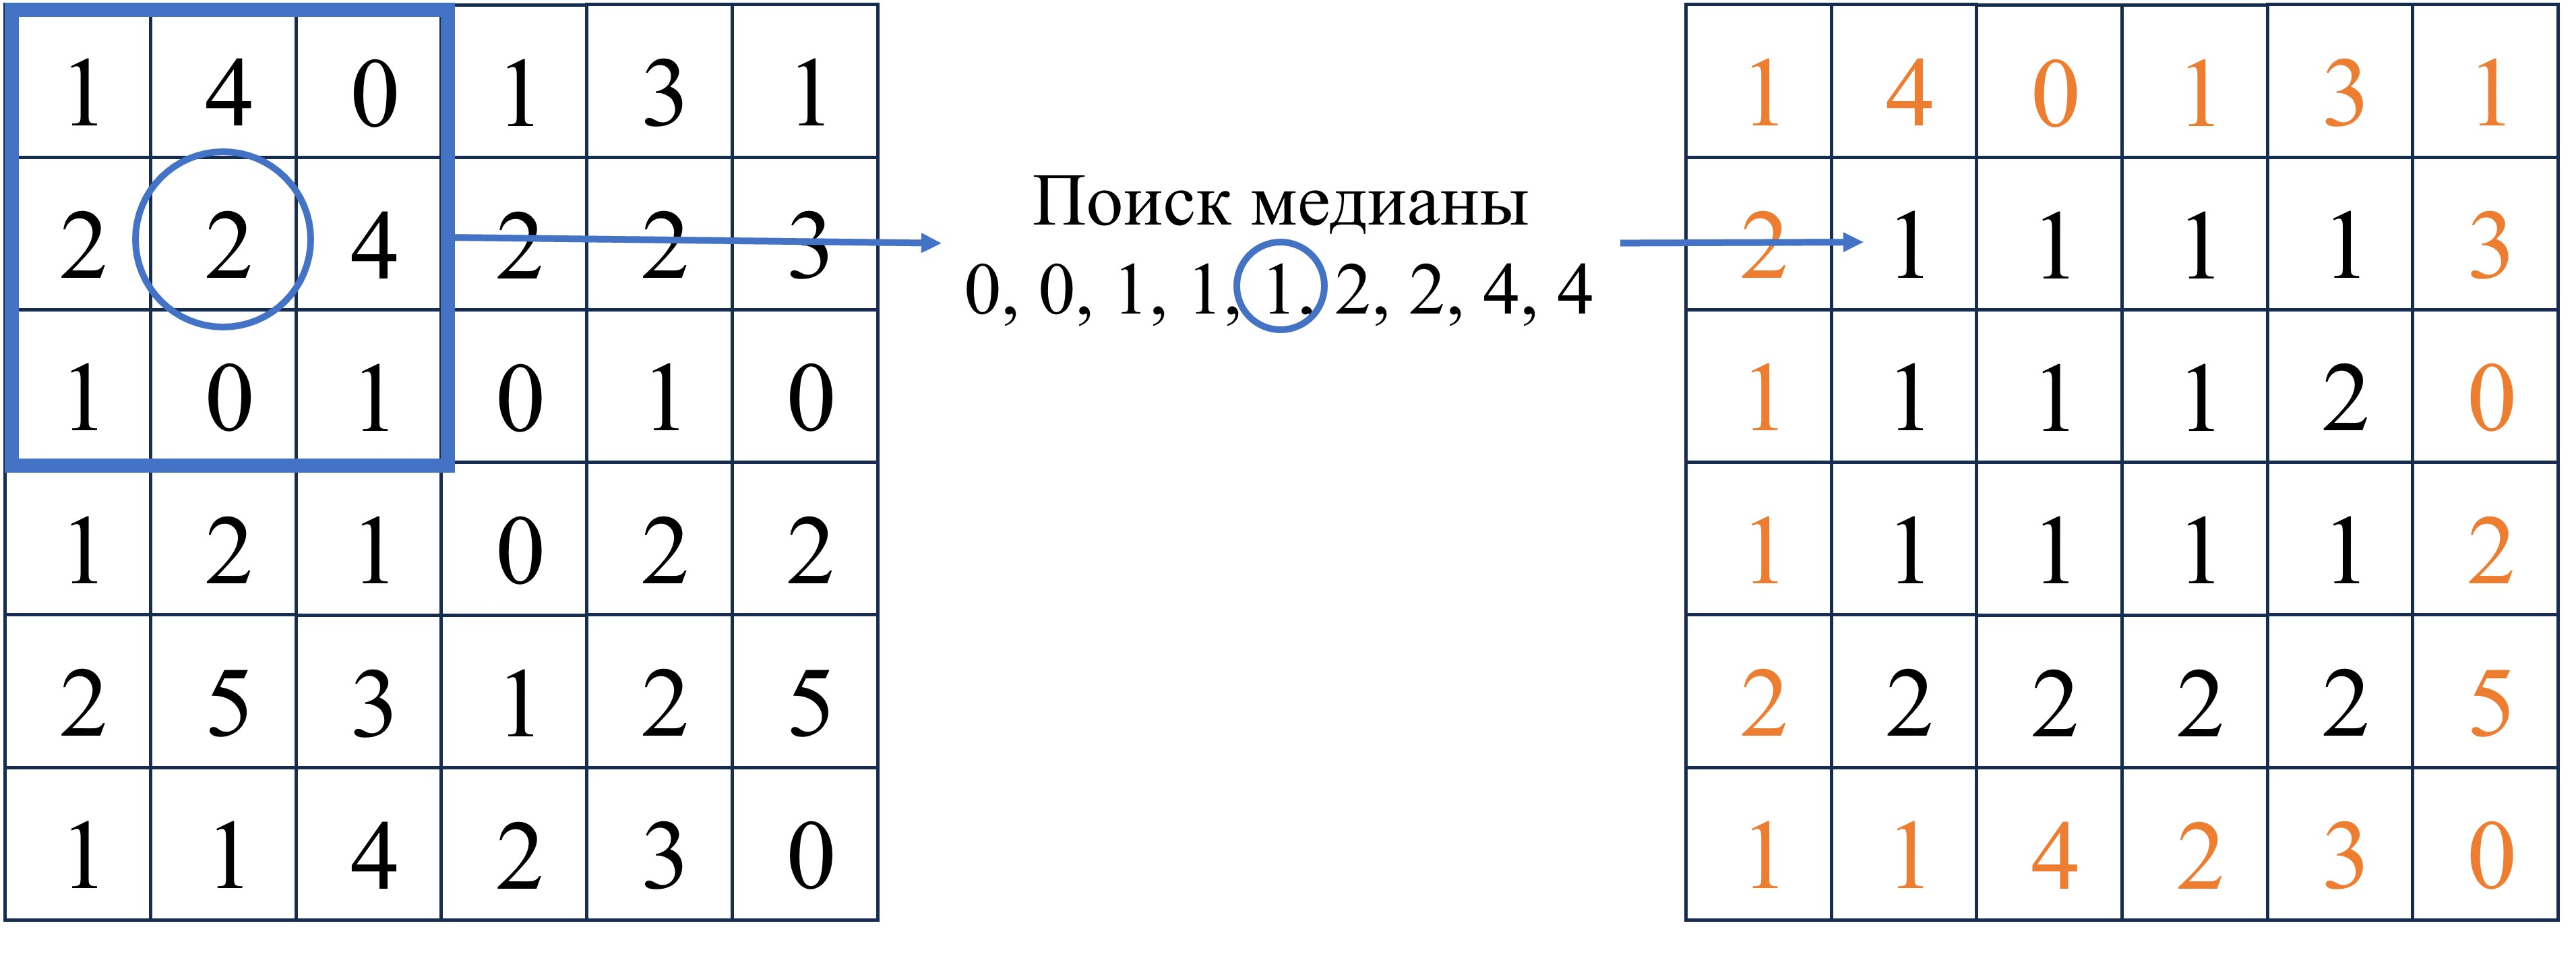

In [ ]:
# Медианный фильтр 3x3 с сохранением граничных значений
IPython.display.Image(filename=FOLDER_PATH + 'data/median_filter.jpg', width=900)

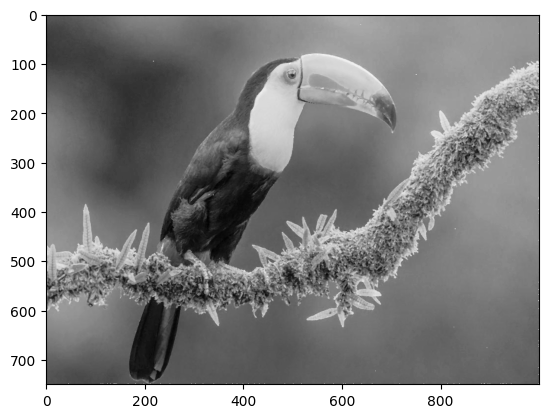

In [52]:
def median_filter(img: ndarray, win_shape: tuple = (3, 3)):
    if win_shape[1]%2 == 0 or win_shape[0]%2 == 0:\
      raise ValueError('Incorrect window shape')

    img_proc = np.copy(img)
    h, w = img.shape
    border_vert = win_shape[0]//2
    border_hor = win_shape[1]//2

    for i in range(border_vert, h - border_vert):
      for j in range(border_hor, w - border_hor):
        win_set = np.asarray([x[j-border_hor:j+border_hor+1] for x in img[i-border_vert:i+border_vert+1]]).flatten()
        win_set.sort()
        img_proc[i][j] = win_set[len(win_set)//2]
    return img_proc

# Проверьте работу функции на примере с картинки выше (для сравнения может пригодиться np.allclose)
im_test = np.array([
    [1.0, 4.0, 0.0, 1.0, 3.0, 1.0],
    [2.0, 2.0, 4.0, 2.0, 2.0, 3.0],
    [1.0, 0.0, 1.0, 0.0, 1.0, 0.0],
    [1.0, 2.0, 1.0, 0.0, 2.0, 2.0],
    [2.0, 5.0, 3.0, 1.0, 2.0, 5.0],
    [1.0, 1.0, 4.0, 2.0, 3.0, 0.0]
])

img_aftermedian = median_filter(img_noized)
plt.imshow(img_aftermedian, cmap='Greys_r')

# 2. Прореживание (децимация, downsampling)
Прореживание как одномерных сигналов, так и изображений, проводится в **два этапа**: сначала применяется фильтр нижних частот (ФНЧ), а затем отбрасываются лишние отсчеты сигнала. Фильтр необходим, чтобы избежать появления в спектре сигнала ложных частот - эффект *алиасинга (aliasing)*. Он связан с тем фактом, что при децимации дискретного сигнала мы отбрасываем некоторые отсчеты, что приводит к понижению частоты дискретизации сигнала и к дальнейшему появлению ложных частот в спектре. Для изображений этот эффект приводит к сильному искажению картинки при изменении её размера.

- **Для выполнения следующих заданий вам потребуется исходное (без дробового шума) изображение.**

    Сначала посмотрим, что будет, если мы уменьшим изображение в 5 раз (по обоим измерениям) без предварительной фильтрации. Отрисуйте получившееся изображение и отобразите его размер.

In [ ]:
# YOUR CODE HERE

Если все было сделано правильно, то картинка будет достаточно сильно искажена. Теперь нужно попробовать применить фильтр к исходной картинке перед отбрасыванием отсчетов, но перед этим познакомимся с линейными фильтрами.

## Линейные фильтры
**Линейный фильтр** - это такая система, в которой к входному сигналу применяется некоторый линейный оператор. В свою очередь стоит напомнить достаточно общее определение *линейной системы*: это такая система, для которой отклик на сумму входных сигналов равен сумме откликов на эти сигналы по отдельности (принцип суперпозиции).

При линейной фильтрации изображения каждый выходной пиксель равен взвешенной сумме пикселей в пределах некоторой области исходной картинки (см. картинку). Иными словами, мы вычисляем **дискретную свертку**:

$$g(x, y)=\sum_{m=-a}^{m=a}\sum_{n=-b}^{n=b}f(m, n)h(x-m, y-n)= \sum_{m=-a}^{m=a}\sum_{n=-b}^{n=b}f(x-m, y-n)h(m, n).$$

Здесь $f(x,y)$, $g(x,y)$ - исходное и выходное изображения, $h(x, y)$ называют **ядром фильтра**, $a=\frac{M-1}{2}$, $b=\frac{N-1}{2}$, $M$, $N$ - размерности ядра.

Графическая интерпретация, достаточно наглядна: у нас имеется ядро фильтра, которое выступает в роли окна (или маски), скользящего по исходной картинке. Внутри окна вычисляем свертку пикселей изображения и ядра, а затем сдвигаем окно.

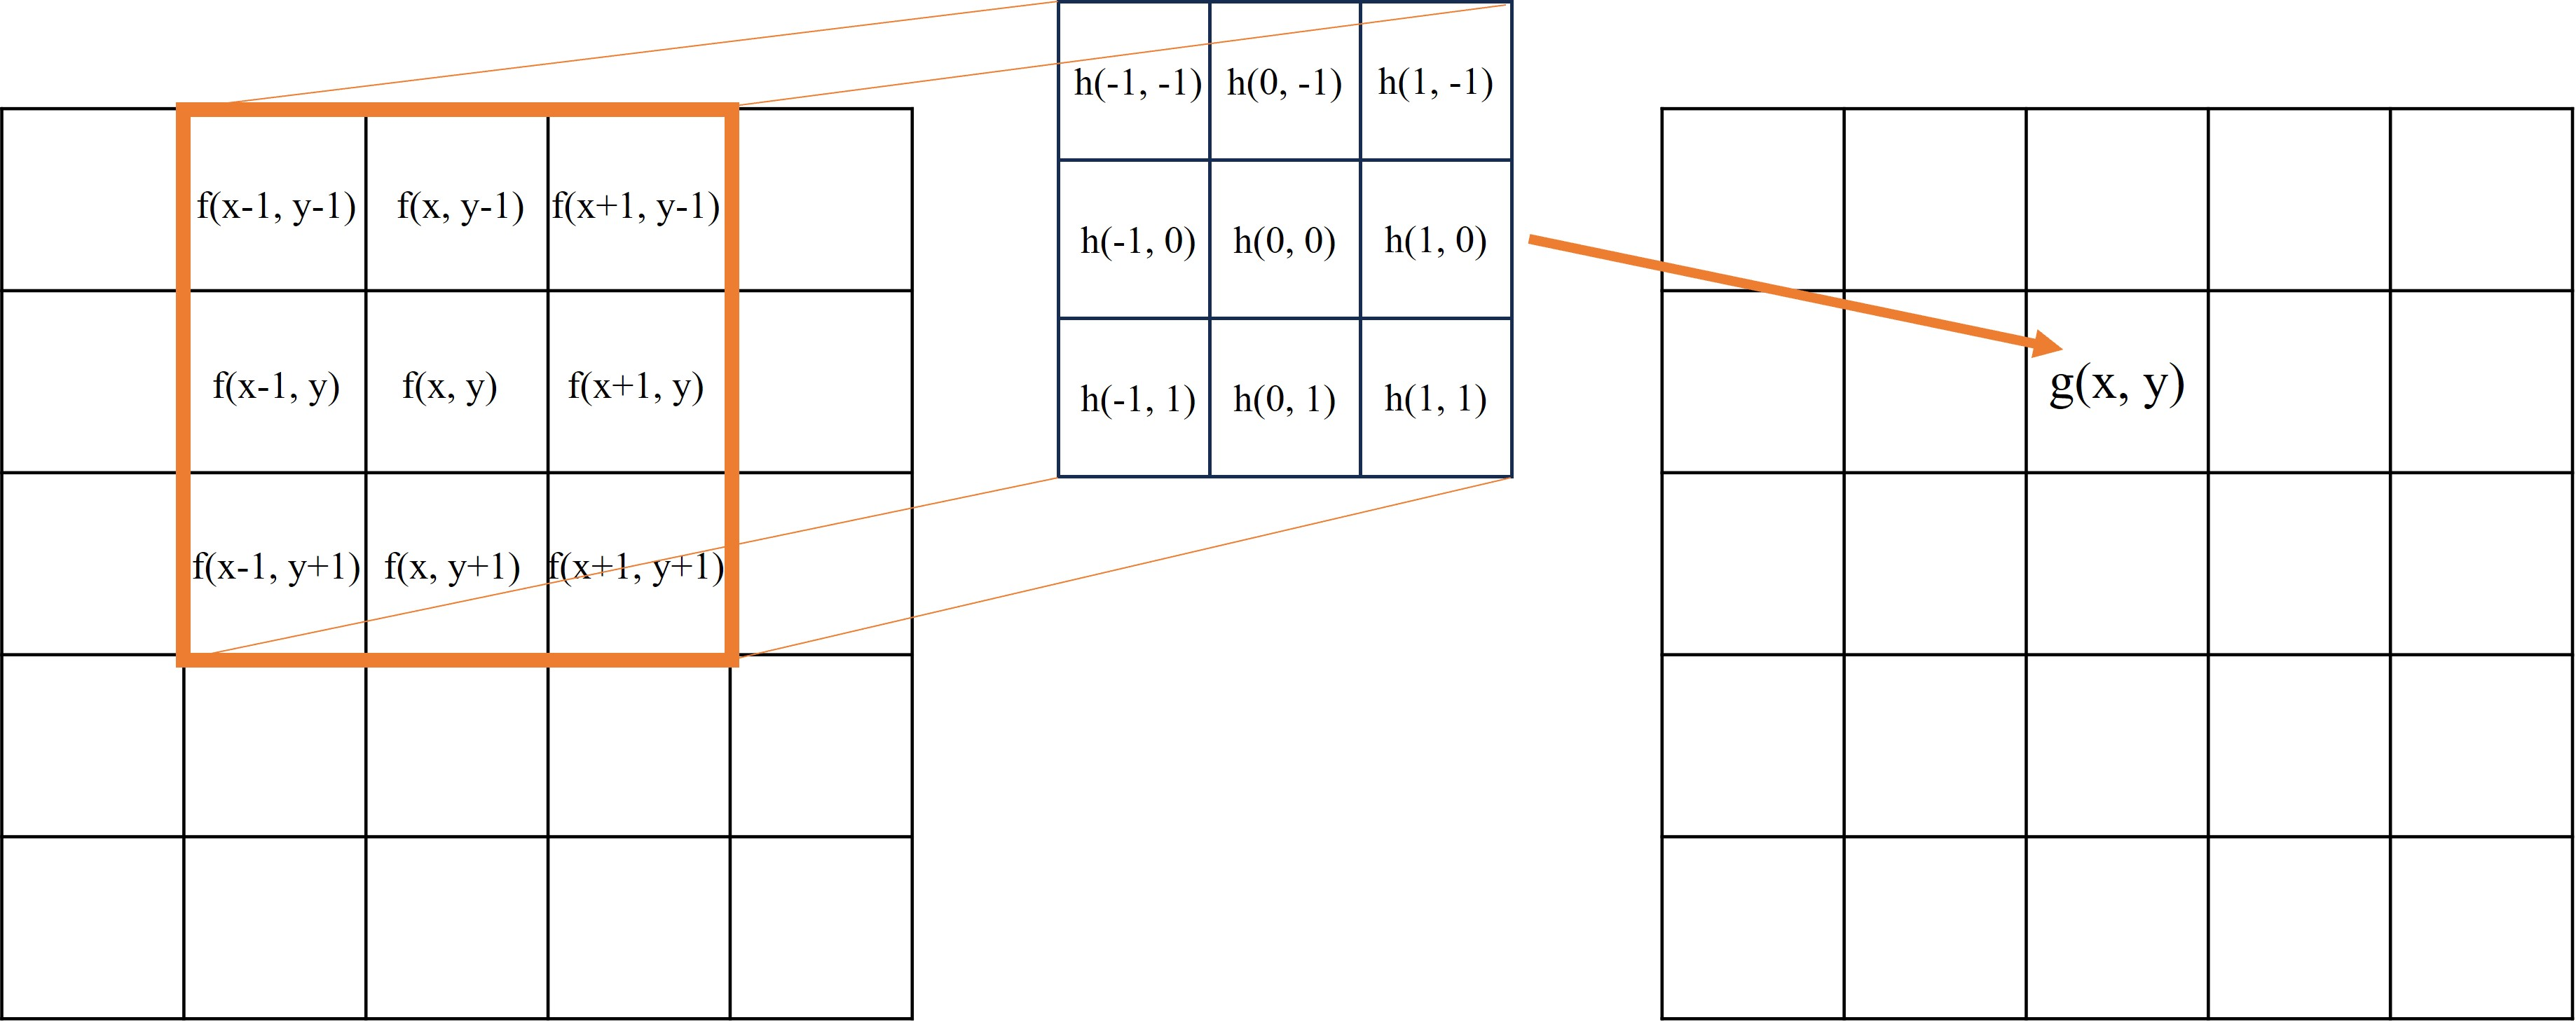

In [ ]:
# Визуализация операции свертки
IPython.display.Image(filename=FOLDER_PATH + 'data/conv.jpg', width=900)

 Можно заметить, что если найти описанным выше образом отфильтрованное изображение, то оно будет меньшего размера, нежели исходное. Дело в том, что ядро фильтра должно выходить за пределы изображения на краях (представьте окно $3\times 3$ и попробуйте поместить в его середину пиксель на краю или углу изображения). Для избежания подобной ситуации картинку можно дополнить пикселями по краям (**padding**).

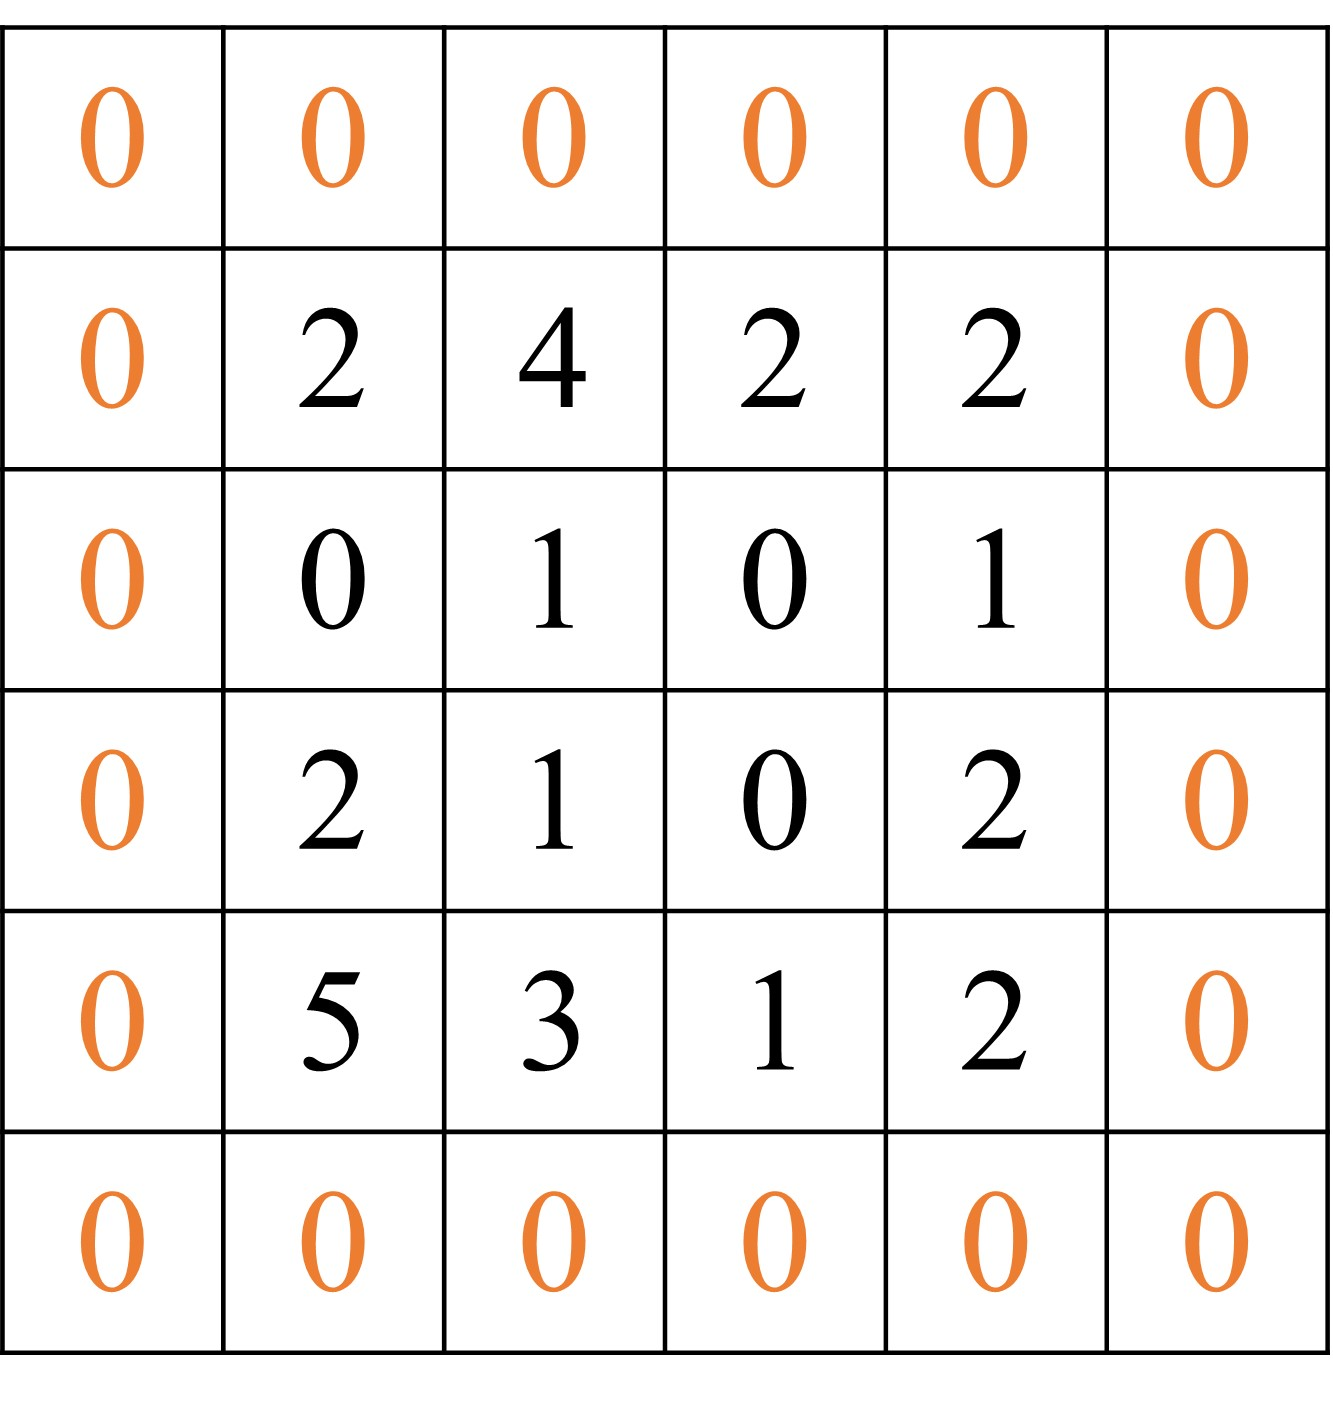

In [ ]:
# Пример паддинга
IPython.display.Image(filename=FOLDER_PATH + 'data/padding.jpg', width=300)

 - Реализуйте функцию `convolve_2d`, вычисляющую свертку двух двумерных сигналов.

In [ ]:
def convolve_2d():
    # YOUR CODE HERE
    pass

- Для фильтрации существует множество разных фильтров. В этом задании нам потребуется *гауссовское ядро*. В одномерном случае оно задается формулой:
$$h_{gauss}(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-x^2/2\sigma^2}.$$
В двумерном случае справедлива формула:
$$h_{gauss}(x, y) = h_{gauss}(x)h_{gauss}(y)$$

 Реализуйте функцию `gauss_kernel`. На вход: размер ядра и среднеквадратическое отклонение $\sigma$. Возвращает функция гауссово ядро.

In [ ]:
def gauss_kernel():
    # YOUR CODE HERE
    pass


print("Gauss kernel: ", )

- Наконец, отфильтруем наше изображение с шумом с помощью реализованных функций. Примените созданный фильтр и после этого проредите картинку. Поэкспериментируйте с размерами ядра и со стандартным отклонением, которые визуально хорошо сглаживают изображение. Не забудьте предварительно добавить нулевые значения на границах, чтобы сохранить размер картинки.

In [ ]:
# YOUR CODE HERE

print("Размер исходной картинки: ", )
print("Размер уменьшенной картинки: ", )

# Сравните работу вашей функции convolve_2d с scipy.signal.convolve2d
# YOUR CODE HERE

# 3. Интерполяция (upsampling)

При интерполяции происходит обратная операция: мы хотим повысить частоту дискретизации нашего сигнала. По сути мы хотим добавить новые отсчеты между уже имеющимися и тем самым увеличить размер картинки. Какие значения примут новые промежуточные отсчеты зависит от схемы, которую мы выберем, но **общий принцип одинаков**: мы добавляем желаемое количество нулей между пикселями, а затем пропускаем картинку через фильтр, в результате чего получаем интерполированное изображение.

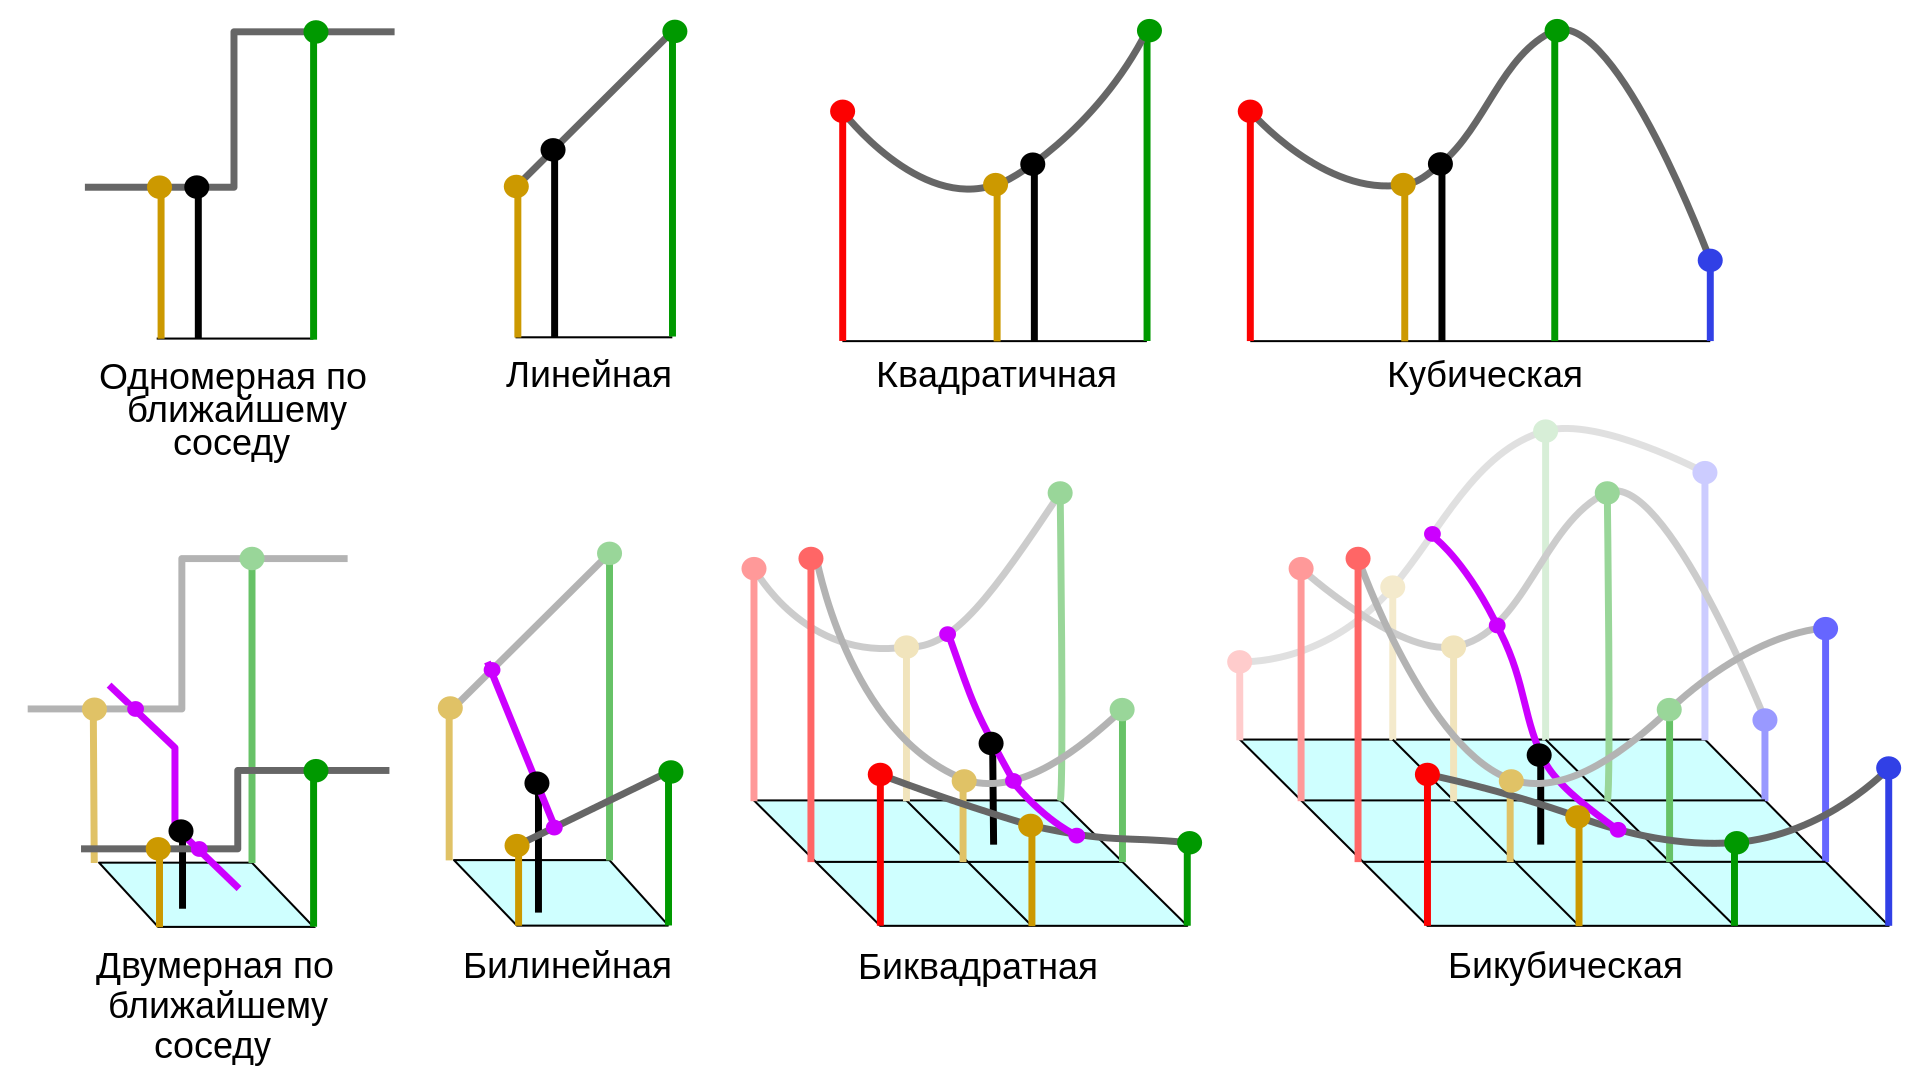

In [ ]:
# Примеры 1D и 2D интерполяций. Известные значения функции выделены цветным, значение функции в интерполируемой точке - черным.
IPython.display.Image(filename=FOLDER_PATH + 'data/interp_types.png', width=800)

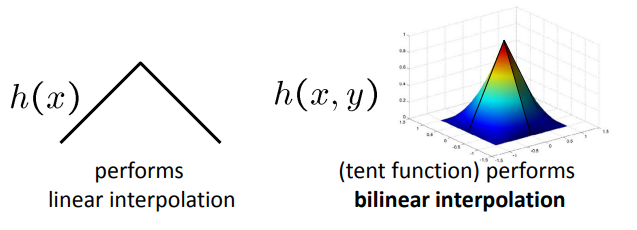

In [ ]:
# Вид ядра для линейной и билинейной интерполяции
IPython.display.Image(filename=FOLDER_PATH + 'data/lin_bilin.png', width=700)

- В этом задании необходимо увеличить картинку, полученную в прошлом пункте, до исходного размера; добавьте нужное количество нулевых строк и столбцов, чтобы получить размер исходного изображения.
- Примените **билинейную интерполяцию**. Она является обобщением линейной интерполяции функции одной переменной для функции двух переменных. Чтобы получить ядро линейной интерполяции можно найти свертку двух массивов, состоящих из единиц:
$$
h(x) = \frac{1}{L} \underbrace{[1,1,...,1]}_{L} \ast \underbrace{[1,1,...,1]}_{L},
$$
где $L$ показывает, во сколько раз необходимо увеличить картинку. Тогда ядро для билинейной интерполяции можно получить как произведение одномерных ядер:
$$
h(x, y) = h(x)^T \cdot h(x)
$$
Реализуйте функцию `bilin_kernel`, принимающую на вход параметр $L$, и отфильтруйте изображение.

- Воспользуйтесь библиотекой `scikit-image` для нахождения **structural similarity index measure (SSIM)** между исходным (до всех преобразований) и восстановленным  изображением. Этот индекс является мерой "похожести" двух изображений. Добейтесь значения SSIM не менее 0.5.

In [ ]:
def bilin_kernel():
    # YOUR CODE HERE
    pass

print("Bilinear kernel: ", )

In [ ]:
# YOUR CODE HERE

print("SSIM: ", )

## **Перед отправкой сохраните ноутбук с именем в следующем формате: 01_Фамилия.ipynb**